In [1]:
suppressWarnings(suppressPackageStartupMessages({
    library(Seurat)
    library(Signac)
    library(EnsDb.Hsapiens.v86)
    library(dplyr)
    library(ggplot2)
    library(bedr)
    library(SeuratDisk)
    library(scales)
    library(reshape2)
    library(Hmisc)
    library(tidyr)
    library(tidyverse)
    library(crayon)
    library(readr)
    library(future)
    library(combinat)
    library("TxDb.Hsapiens.UCSC.hg38.knownGene")
    library(GenomicRanges)
    library(GenomicFeatures)
    library(rsnps)
    library(biomaRt)
    library(ggpubr)
    library(gridExtra)
    library(patchwork)
}))
options(timeout=100)
source('/home/vsevim/prj/workflows/ckd/secondary/helper_functions_for_diffex.r')

# Definitions etc

In [2]:
set.seed(1234)
options(digits=2)
stats <- c()

In [3]:
options(future.globals.maxSize= 250 * 1024^3) # 650Gb
# plan()

# Enable parallelization
plan(sequential)
plan("multicore", workers = 64)

In [4]:
if(!exists("papermill_run")) {
    prj_name = "Screen1_66guides"
    data_subdir_suffixes = "L1,L2,L3,L4"     
    secondary_a_path = "/home/vsevim/prj/1012-ckd/S1/analysis/secondary/"
    save_seurat_h5 = "YES"
}

In [5]:
custom_theme <- theme(
  plot.title = element_text(size=16, hjust = 0.5), 
  legend.key.size = unit(0.7, "cm"), 
  legend.text = element_text(size = 14))

### Load Seurat file

In [6]:
integrated_h5_path <- "/home/vsevim/prj/1012-ckd/S1/analysis/secondary/integrated/seurat_objects/integrated.h5seurat"
seurat_combined    <- LoadH5Seurat(integrated_h5_path, verbose = FALSE)
seurat_combined    <- subset(seurat_combined, subset=status=='singlet')

Validating h5Seurat file

Warning message:
"Adding a command log without an assay associated with it"


Normalize RNA counts by <font color='red'>NormalizeData</font>  before running FindMarkers

In [7]:
seurat_rna = CreateSeuratObject(seurat_combined[['RNA']])
seurat_rna <- NormalizeData(seurat_rna)
seurat_rna@meta.data <- seurat_combined@meta.data

### Load THRESHOLDS.tsv

In [8]:
thr_f_name = paste0(secondary_a_path, "/integrated/THRESHOLDS.tsv")
df_thresholds = read.table(thr_f_name, header=T, strip.white = T)
df_thresholds <- df_thresholds %>% pivot_wider(names_from = batch, values_from = threshold)
df_thresholds <- as.data.frame(df_thresholds)

### Load guide df

In [9]:
df_guide = read.table("/home/vsevim/prj/1012-ckd/S1/scripts/library_csv/66CRISPRi_ref_for_diffex.txt", sep = "\t", header = T, strip.white = T)
head(df_guide)

,gene,guide1,guide2,alias,subclass,class
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,CD13,CD13-1a,CD13-1b,ANPEP,tss,targeting
2,CD55,CD55-1a,CD55-1b,CD55,tss,targeting
3,CD73,CD73-1a,CD73-1b,NT5E,tss,targeting
4,FUBP1,FUBP1-1a,FUBP1-1b,FUBP1,tss,targeting
5,C15orf40,C15orf40-1a,C15orf40-1b,C15orf40,tss,targeting
6,MAFF,MAFF-1a,MAFF-1b,MAFF,tss,targeting


## FeaturePlot singlet & doublet

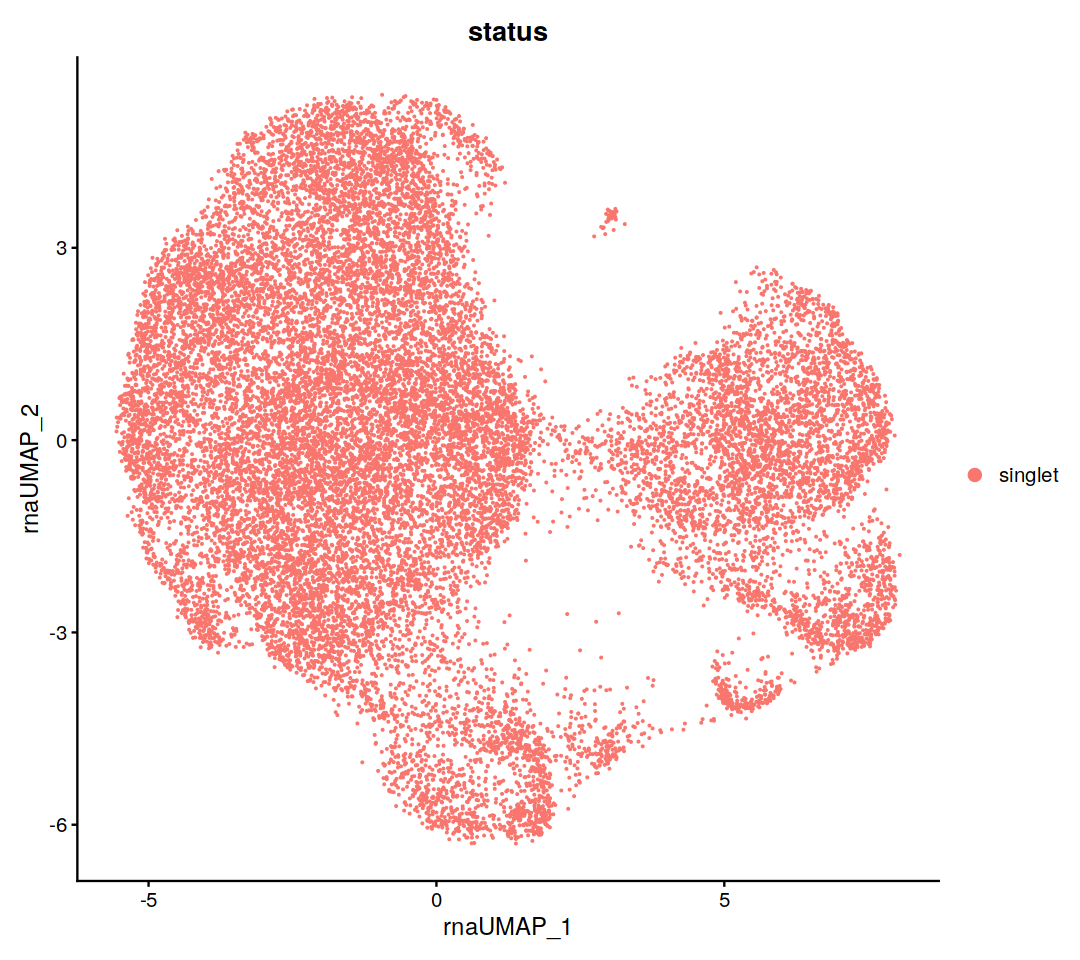

In [10]:
options(repr.plot.width=9, repr.plot.height=8)
DimPlot(seurat_combined, group.by='status')

# Differential expression

## Select perturbed/control cells
Find guide+ (perturbed) and guide- (unperturbed) cells for each guide

In [11]:
libraries = unique(seurat_combined$library)
seurat_libs = list()
for(i in seq_along(libraries)){ 
    lib = libraries[i]
    seurat_libs[[i]] = subset(seurat_combined, subset = library == lib)
}
names(seurat_libs) <- libraries

In [12]:
get_all_perturbed_cells_by_guide <- function(seurat_obj_libs) {
    perturbed_cells_by_guide = list()

    for(i in 1:nrow(df_thresholds)){  
        perturbed_cells_in_all_libs = list()
        guide = df_thresholds$guide[i]
        # Loop over libraries
        for(lib in libraries){        
            seurat_lib = seurat_obj_libs[[lib]]
            threshold = df_thresholds[i, lib]        
            #cat(blue(guide, lib, threshold, "\n"))
            cells_in_lib = Cells(seurat_lib)        
            sgrna_counts = seurat_lib[['sgRNA']]@counts
            select_perturbed = sgrna_counts[guide, cells_in_lib] >= threshold
            perturbed_cells_in_library = cells_in_lib[select_perturbed]
            #cat(length(cells_in_lib), "in", lib, guide, length(perturbed_cells_in_library), "cells >", threshold, "\n")        
            perturbed_cells_in_all_libs = append(perturbed_cells_in_all_libs, perturbed_cells_in_library)
        }
        perturbed_cells_by_guide[[i]] = perturbed_cells_in_all_libs
    }
    names(perturbed_cells_by_guide) <- df_thresholds$guide
    perturbed_cells_by_guide
}


In [13]:
perturbed_cells_by_guide <- get_all_perturbed_cells_by_guide(seurat_libs) 
length(perturbed_cells_by_guide[[3]])

[1] 947

In [14]:
df_thresholds$guide[grepl("NT" , df_thresholds$guide)]

[1] "NTCE1-1a" "NTCE3-1a" "NTCE3-1b" "NTCE4-1a" "NTCE4-1b"

In [15]:
# Mark cells that are positive for given guides as target_positive, all others as target_negative
mark_plasmid_pos_neg <- function(seurat_obj, perturbed_cells_by_guide, guides, print_counts = T) {
    all_cells = Cells(seurat_obj)
    perturbed_cells = c()
    dummy_perturbed = c()
    
    for(guide in guides) {
        dummy_perturbed = unlist(perturbed_cells_by_guide[[guide]])
        perturbed_cells = union(perturbed_cells, dummy_perturbed)    
        #cat(guide," ", length(perturbed_cells), "\n")
    }

    unperturbed_cells = unlist(setdiff(all_cells, perturbed_cells))
    Idents(seurat_obj) <- "plasmid_negative"
    seurat_obj <- SetIdent(seurat_obj, cells = perturbed_cells, value = "plasmid_positive") 

    if(print_counts) {
        n_gplus   = length(perturbed_cells)
        n_gminus = length(unperturbed_cells)    
        cat(blue("Plasmid+ =",n_gplus, "; Plasmid- =", n_gminus, "\n"))
    }
    
    seurat_obj
}


### Applications

Find all unperturbed cells: these are the cells with either no guides or only NT guides

In [16]:
select_targeting_guides = df_guide$class == 'targeting'
df_targeting  = df_guide[select_targeting_guides, ]
targeting_guides = c(df_targeting$guide1, df_targeting$guide2)
seurat_rna <- mark_target_pos_neg(seurat_rna, perturbed_cells_by_guide, targeting_guides)
unperturbed_cells <- Cells(subset(seurat_rna, idents='target_negative'))

Guide+ = 20176 ; Guide- = 1188 


# DE for all Targeting Guide pairs

In [17]:
count_idents <- function(seurat_obj, idents) {
    length(Cells(subset(seurat_obj, idents = idents)))
}

In [18]:
df_targeting = filter(df_guide, class=='targeting')
df_de = NULL
genes_to_skip = c("DE5", "CD55", "CSTB")
genes_to_skip = c()
lfc_threshold = 0.15

for(i in nrow(df_targeting)){
    target = df_targeting[i, 'alias']
    if(target %in% genes_to_skip){
        cat(red("Skipping", target, "\n"))
        next
    }
    guides_on_plasmid = unlist(as.list(t(df_guide[1, c('guide1', 'guide2')])))
    cat(blue(target,":"), paste(guides_on_plasmid, collapse=","),"\n")
    seurat_dummy <- mark_guide_pos_neg(seurat_rna, perturbed_cells_by_guide, guides_on_plasmid, print_counts = T)
    
    markers <- FindMarkers(
        object = seurat_dummy,
        slot = "data",
        ident.1 = 'plasmid_positive',
        ident.2 = 'plasmid_negative',
        test.use = "MAST",
        latent.vars = c("library", "donor"),
        logfc.threshold = lfc_threshold,
        verbose = FALSE
    )
    # latent.vars = c('library') 
    if(nrow(markers)==0) {
        cat(Red("No DE genes", target,  "\n"))
    }
    markers$de_gene = rownames(markers)
    markers$target = target
    rownames(markers) <- NULL
    df_de = rbind(df_de, markers)
}

DE17 : CD13-1a,CD13-1b 


ERROR: Error in mark_guide_pos_neg(seurat_rna, perturbed_cells_by_guide, guides_on_plasmid, : could not find function "mark_guide_pos_neg"


Write to file

In [ ]:
lfc = gsub("\\.", "_", lfc_threshold)
de_f_name = paste0(secondary_a_path, "/integrated/DE_outputs/DE_genes_by_plasmid_LFC_", lfc, "UNFILTERED.tsv")
write.table(df_de, de_f_name, sep="\t", quote = F, row.names = F)

### Filter out spurious hits

In [ ]:
# Some genes come up as differentially expressed all the time
# Filter those out, and write to another file
funky_de_genes = c("HMOX1", "AL357507.1", "IFI27", "AL138828.1", "SQSTM1", "PLCG2", "PLIN2", "SAA1", "RARRES2", "CDKN1A")
df_de = filter(df_de, !(de_gene  %in% funky_de_genes))

de_f_name = paste0(secondary_a_path, "/integrated/DE_outputs/DE_genes_by_plasmid_LFC_", lfc, "_FILTERED.tsv")
write.table(df_de, de_f_name, sep="\t", quote = F, row.names = F)

# Inpect DE results

In [ ]:
de_f_name = paste0(secondary_a_path, "/integrated/DE_outputs/DE_genes_minlogfc_0p15.tsv")
df_de = read.table(de_f_name, sep="\t",  header = T)

Print top high-confidence hits

In [ ]:
df_de %>% filter(avg_log2FC < 0) %>% arrange(p_val_adj) %>% head(30)

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj,de_gene,target
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
1,0.0e+00,-0.57,1.00,1.00,0.0e+00,FTH1,FTH1
2,8.1e-206,-0.72,0.84,0.92,3.0e-201,LGALS3,LGALS3
3,1.7e-179,-0.46,0.95,0.98,6.2e-175,TKT,TKT
4,4.4e-159,-0.59,0.96,0.97,1.6e-154,CTSB,CTSB
5,1.7e-149,-0.58,0.46,0.81,6.2e-145,NT5E,NT5E
6,3.5e-140,-0.29,0.71,0.82,1.3e-135,PLIN3,PLIN3
7,4.9e-130,-0.33,0.30,0.63,1.8e-125,C15orf40,C15orf40
8,7.7e-116,-0.50,0.57,0.80,2.8e-111,ANPEP,ANPEP
9,1.4e-103,-0.31,0.57,0.71,5.1e-99,NDRG1,DE6


In [ ]:
targets = unique(df_de$target)

for(t in targets){
    print(filter(df_de, target == t) %>% head(1))
    #cat(yellow("------------------------------------------------------------\n\n\n"))

}

     p_val avg_log2FC pct.1 pct.2 p_val_adj de_gene target
1 7.7e-116       -0.5  0.57   0.8  2.8e-111   ANPEP  ANPEP
    p_val avg_log2FC pct.1 pct.2 p_val_adj de_gene target
1 2.1e-86      -0.19  0.16   0.4   7.6e-82    CD55   CD55
     p_val avg_log2FC pct.1 pct.2 p_val_adj de_gene target
1 1.7e-149      -0.58  0.46  0.81  6.2e-145    NT5E   NT5E
    p_val avg_log2FC pct.1 pct.2 p_val_adj de_gene target
1 2.6e-50      -0.23  0.54  0.69   9.4e-46   FUBP1  FUBP1
     p_val avg_log2FC pct.1 pct.2 p_val_adj  de_gene   target
1 4.9e-130      -0.33   0.3  0.63  1.8e-125 C15orf40 C15orf40
    p_val avg_log2FC pct.1 pct.2 p_val_adj de_gene target
1 5.5e-31      -0.23  0.63  0.72     2e-26   PTPN3   MAFF
  p_val avg_log2FC pct.1 pct.2 p_val_adj de_gene target
1     0      -0.57     1     1         0    FTH1   FTH1
     p_val avg_log2FC pct.1 pct.2 p_val_adj de_gene target
1 3.5e-140      -0.29  0.71  0.82  1.3e-135   PLIN3  PLIN3
     p_val avg_log2FC pct.1 pct.2 p_val_adj de_gene target
1 1

# Visualize Knockdowns

## TSS controls

[1] "ANPEP"
Guide+ = 1390 ; Guide- = 19973 
[1] "CD55"
Guide+ = 1298 ; Guide- = 20065 
[1] "NT5E"
Guide+ = 889 ; Guide- = 20474 
[1] "FUBP1"
Guide+ = 1060 ; Guide- = 20303 
[1] "C15orf40"
Guide+ = 974 ; Guide- = 20389 
[1] "MAFF"
Guide+ = 1043 ; Guide- = 20320 


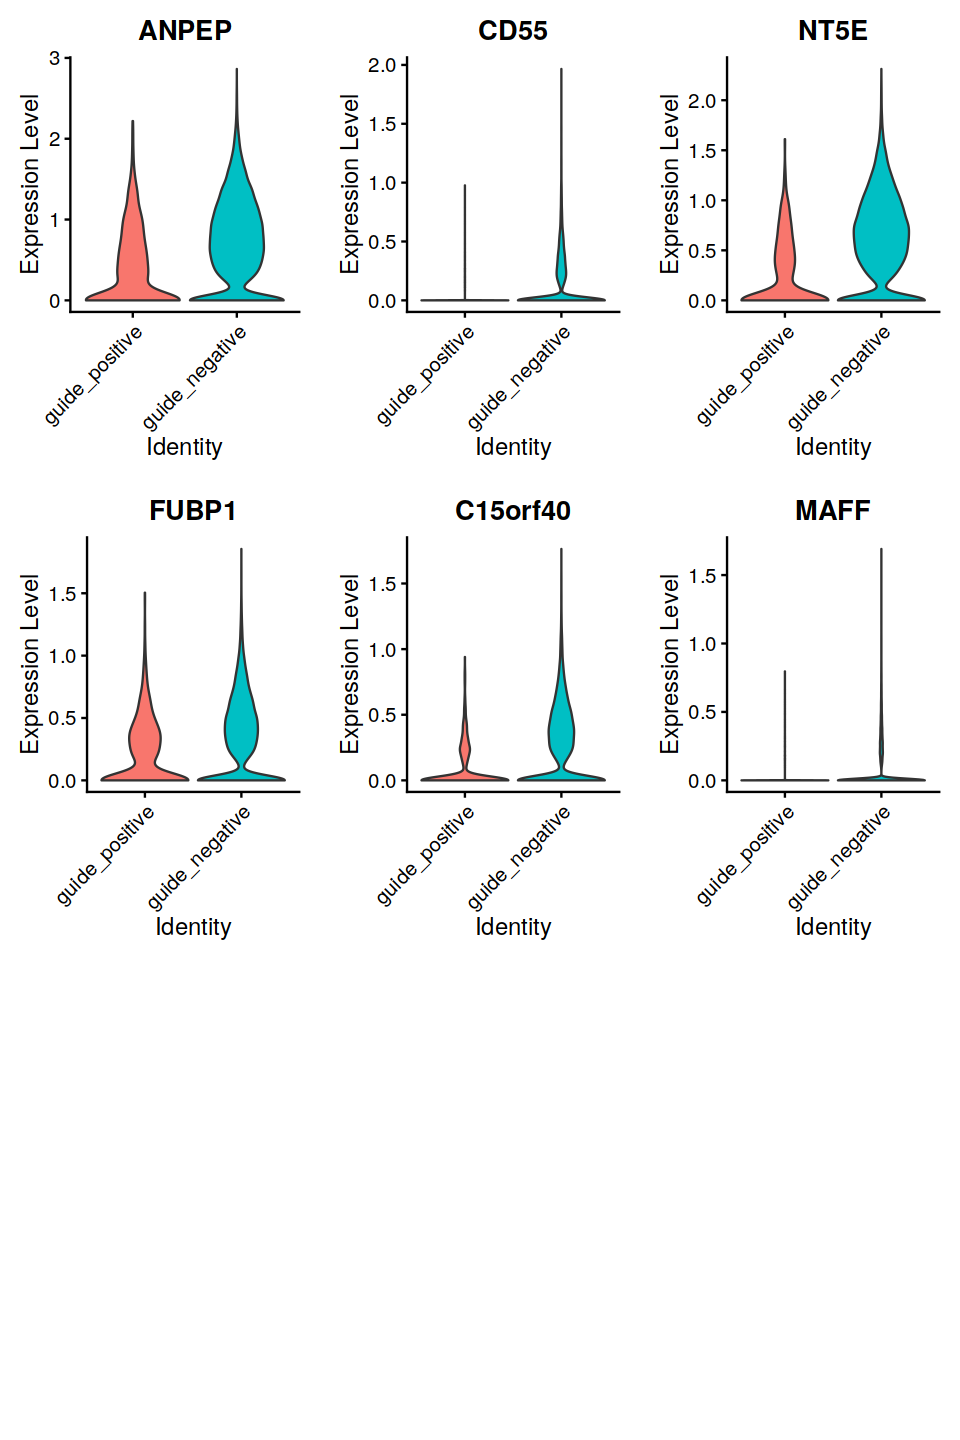

In [ ]:
targets = unique(filter(df_guide, subclass=='tss')$alias)
plots = vlnplot_for_targets(seurat_rna, df_guide, perturbed_cells_by_guide, targets)
options(repr.plot.width=8, repr.plot.height=12)
ggarrange(plotlist=plots, ncol=3, nrow = 3)

## DE controls

[1] "FTH1"
Guide+ = 3997 ; Guide- = 17366 
[1] "PLIN3"
Guide+ = 2357 ; Guide- = 19006 
[1] "TKT"
Guide+ = 2255 ; Guide- = 19108 
[1] "LGALS3"
Guide+ = 2451 ; Guide- = 18912 
[1] "CSTB"
Guide+ = 2642 ; Guide- = 18721 
[1] "CTSB"
Guide+ = 2582 ; Guide- = 18781 
[1] "KLF6"
Guide+ = 2550 ; Guide- = 18813 


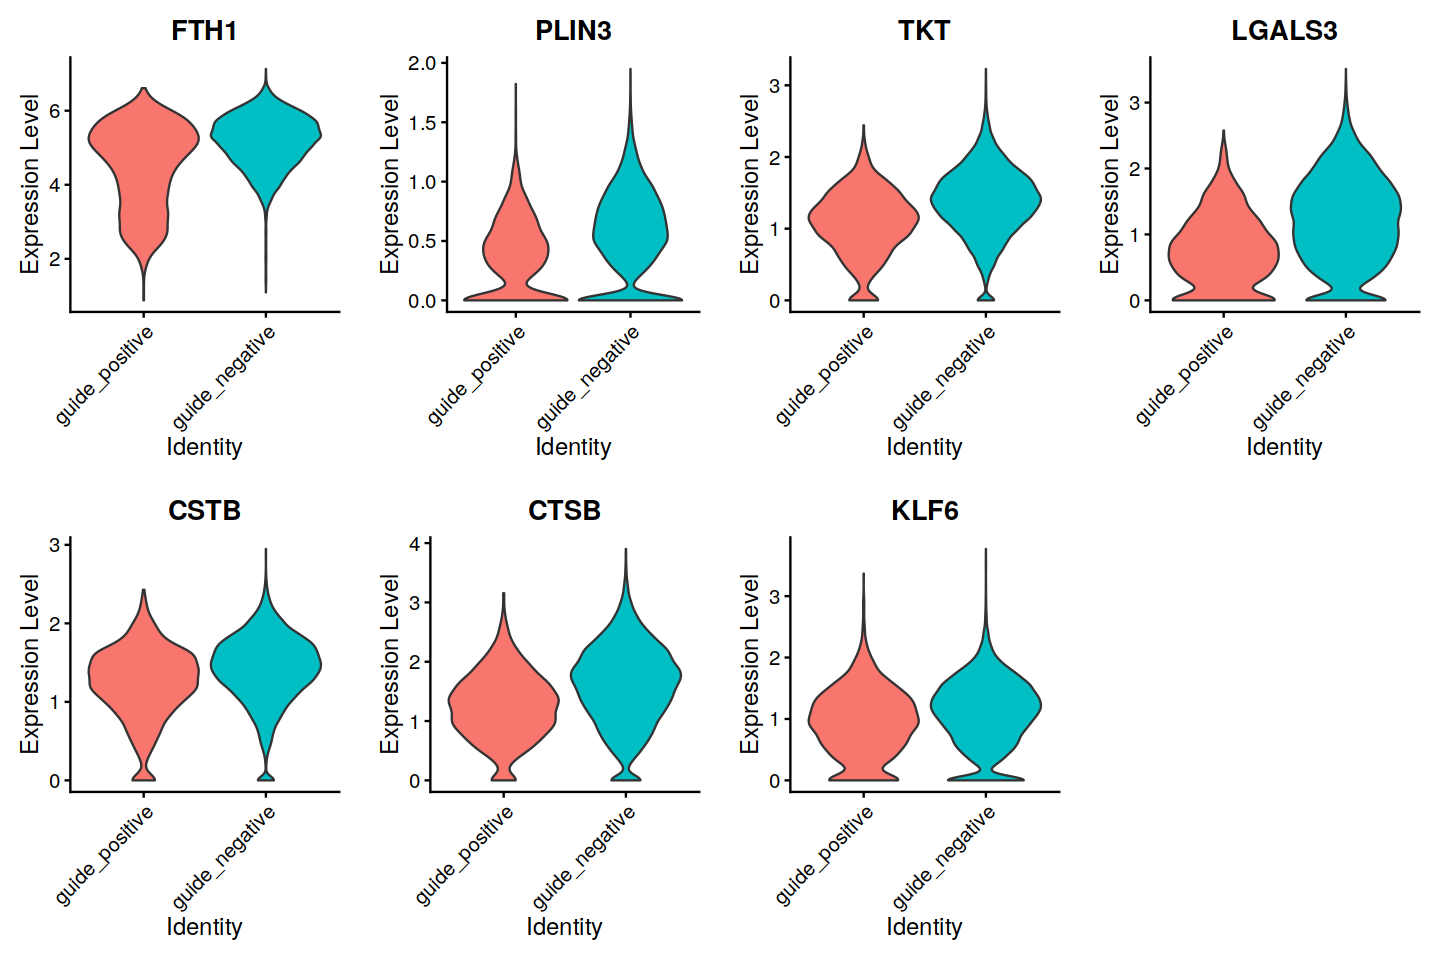

In [ ]:
targets = unique(filter(df_guide, subclass=='de_control')$alias)
plots = vlnplot_for_targets(seurat_rna, df_guide, perturbed_cells_by_guide, targets)
options(repr.plot.width=12, repr.plot.height=8)
ggarrange(plotlist=plots, ncol=4, nrow = 2)

## CKD DE 

[1] "DE6"
Guide+ = 3244 ; Guide- = 18120 


Picking joint bandwidth of 0.0585

Picking joint bandwidth of 0.0742

Picking joint bandwidth of 0.0949



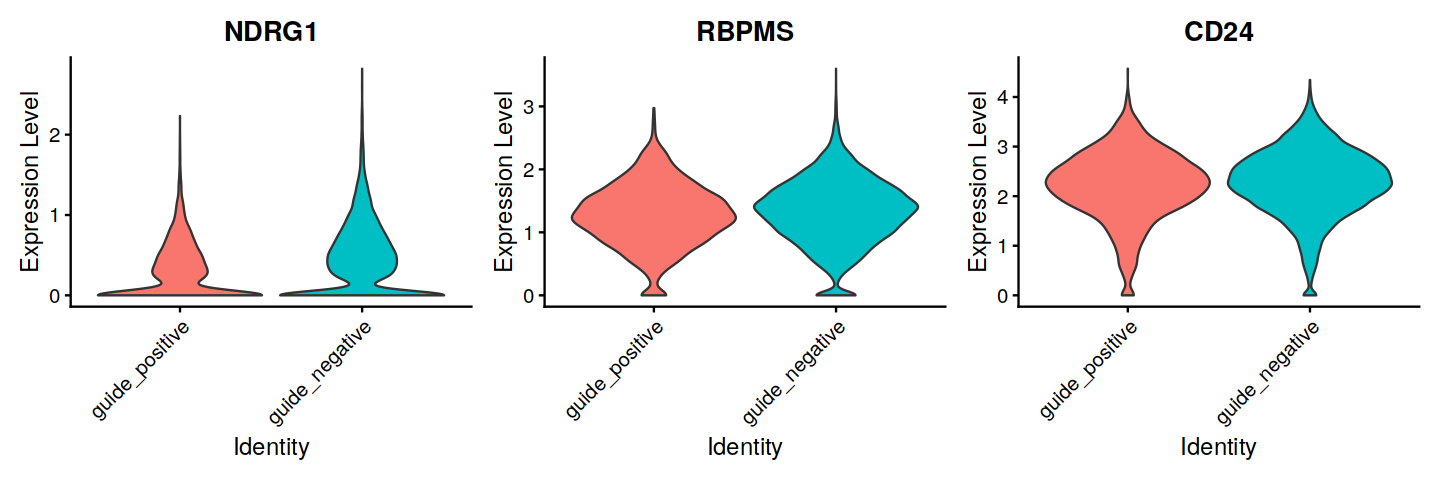

[1] "DE15"
Guide+ = 2662 ; Guide- = 18701 


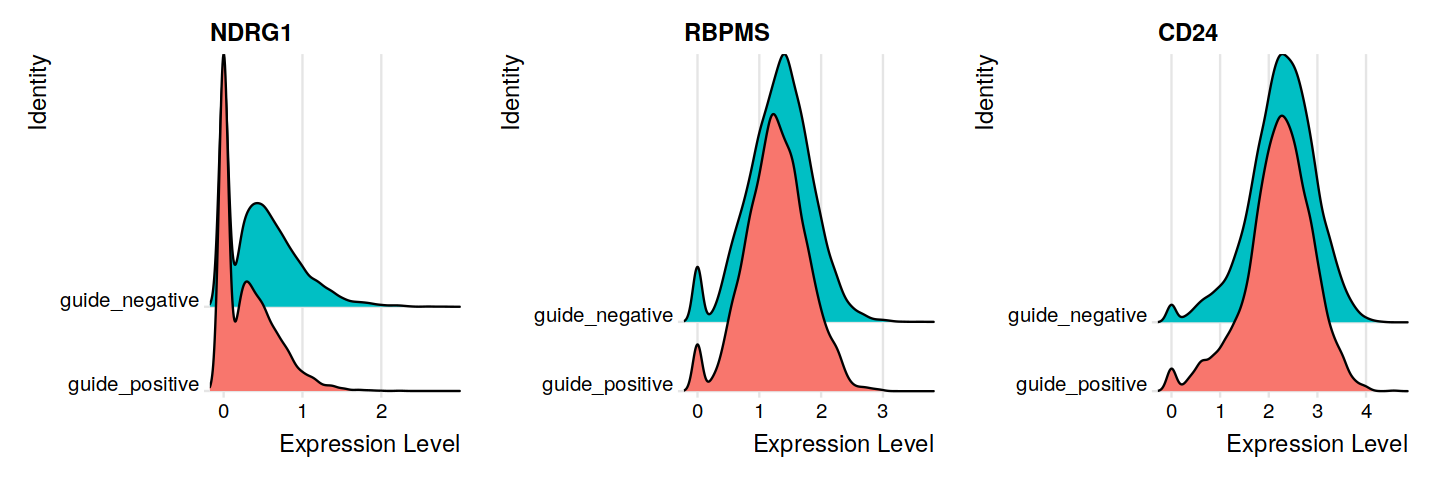

Picking joint bandwidth of 0.0659

Picking joint bandwidth of 0.0752

Picking joint bandwidth of 0.099



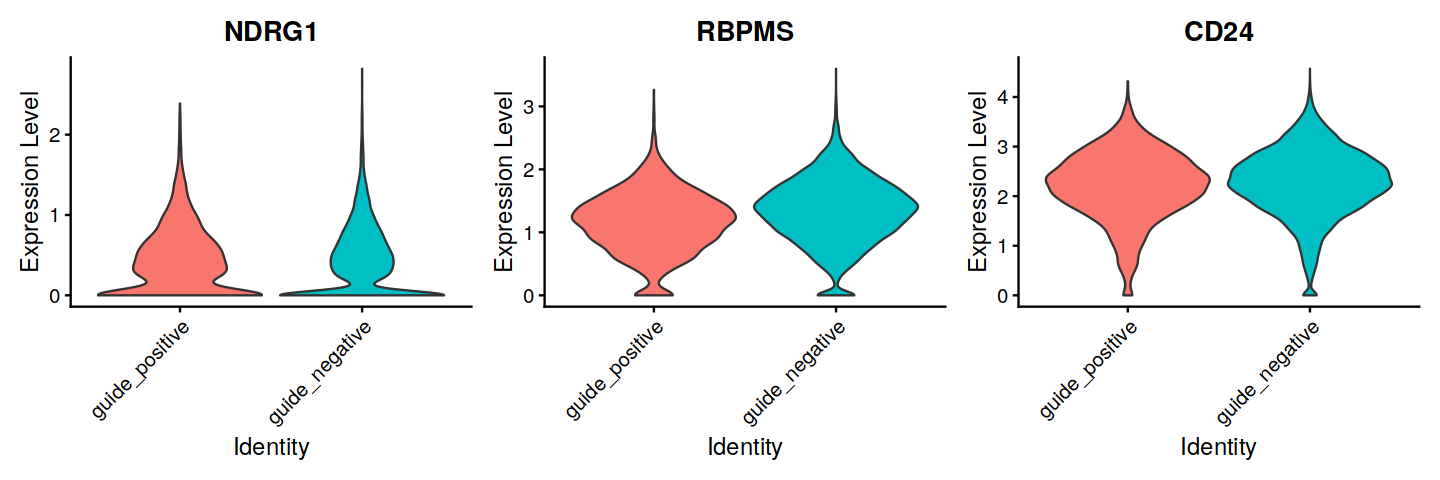

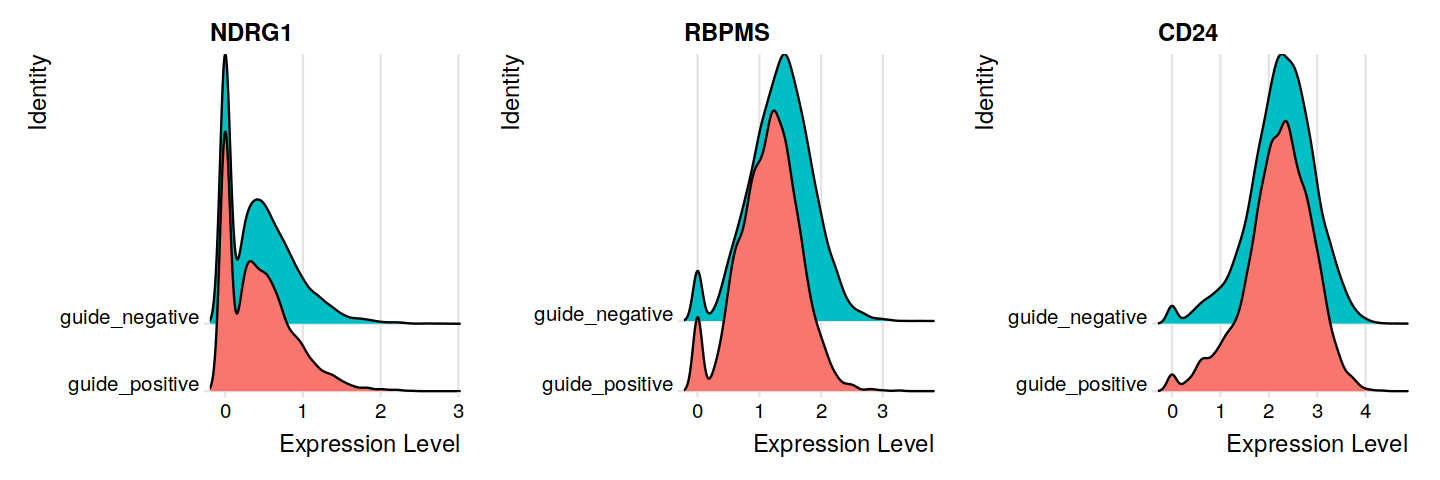

In [ ]:
targets = c("DE6", "DE15")
regulated_genes = c("NDRG1", "RBPMS", "CD24")

for(i in seq_along(targets)) {
    target = targets[i]
    print(target)
    guides = get_guides_by_subclass(df_guide, 'alias', target)
    seurat_rna <- mark_guide_pos_neg(
        seurat_rna, 
        perturbed_cells_by_guide, 
        guides, 
        print_counts = T
    )

    options(repr.plot.width=6, repr.plot.height=4)
    plt <- VlnPlot(
        object = seurat_rna,
        features = regulated_genes, 
        idents = NULL, 
        pt.size = 0, 
        sort = F, 
        ncol = 3,    
    ) 

    # options(repr.plot.width=12, repr.plot.height=4)
    # plt2 <- RidgePlot(
    #     object = seurat_rna,
    #     features = regulated_genes, 
    #     idents = NULL,  
    #     sort = F, 
    #     ncol = 3,    
    # ) 

    print(plt) 
    # print(plt2)
}



# Check DE for genes near SNPs

In [ ]:
select_distal  = df_guide$subclass == 'ckd_de'
df_snps = unique(df_guide[select_distal, c('gene','alias')])

In [ ]:
snp_coords = ncbi_snp_query(df_snps$gene)

Getting info about the following rsIDs: rs2823139, rs7642977, rs78581838, rs7707989, rs527616, rs10283362, rs34861762, rs16874072, rs881858, rs4669722, rs76839935, rs6839100, rs11154336, rs4720089, rs2979488, rs2661503, rs10224210



In [ ]:
snp_upstream_range   = 100000
snp_downstream_range = 100000

df_snp_coords        = data.frame(chr=paste0("chr", snp_coords$chromosome))
df_snp_coords$start  = snp_coords$bp + snp_upstream_range
df_snp_coords$end    = snp_coords$bp + snp_downstream_range
df_snp_coords$strand = '*'
df_snp_coords$rsid   = snp_coords$rsid
#snp_granges = makeGRangesFromDataFrame(df_dummy)

In [ ]:
ensembl <- useEnsembl(biomart = "genes", dataset = "hsapiens_gene_ensembl")
searchDatasets(mart = ensembl, pattern = "hsapiens")
mart <- useMart("ensembl")
mart <- useDataset("hsapiens_gene_ensembl", mart)

## Find the neighbors of each SNP

In [ ]:
genes_in_assay = rownames(seurat_rna[['RNA']]@counts)

In [ ]:
attributes <- c("ensembl_gene_id","chromosome_name", "start_position","end_position","strand","hgnc_symbol", "refseq_ncrna", "refseq_ncrna_predicted" )
filters    <- c("chromosome_name","start","end")
snp_upstream_range   = 1000000
snp_downstream_range = 1000000
snp_neigbors_list = list()

for(i in 1:nrow(snp_coords)) {
    snp = snp_coords[i, ]
    cat(blue(snp$rsid,"\t"))
    chr = snp$chromosome
    start = snp$bp - snp_upstream_range
    end   = snp$bp + snp_downstream_range
    
    values <- list(chromosome=chr, start = start, end = end)
    neighbor_genes <- getBM(attributes=attributes, filters=filters, values=values, mart=mart)
    n_neighbors   = length(unique(neighbor_genes$ensembl_gene_id))
    select_non_na = !is.na(neighbor_genes$hgnc_symbol) & (neighbor_genes$hgnc_symbol != "")
    neighbor_genes <- neighbor_genes[select_non_na, ]
    n_neighbors_w_names = length(unique(neighbor_genes$hgnc_symbol))
    cat(blue(n_neighbors, "neigbors found,", n_neighbors_w_names, "have a name, "))

    if(n_neighbors_w_names > 0){        
        dummy = as.vector(unique(neighbor_genes$hgnc_symbol))
        # some neighbors are not in the cellranger reference. Remove those.
        select_genes_in_assay = dummy %in% genes_in_assay
        cat(blue(sum(select_genes_in_assay), " found in assay"))
        print(snp_neigbors_list)
        snp_neigbors_list[[snp$rsid]] = dummy[select_genes_in_assay]
        cat(snp_neigbors_list[[snp$rsid]], "\n")
    }else { print("") }
}

rs2823139 	36 neigbors found, 21 have a name, 9  found in assaylist()
LIPI RBM11 HSPA13 SAMSN1 SAMSN1-AS1 LINC02246 NRIP1 USP25 MIR99AHG 
rs7642977 	54 neigbors found, 36 have a name, 26  found in assay$rs2823139
[1] "LIPI"       "RBM11"      "HSPA13"     "SAMSN1"     "SAMSN1-AS1"
[6] "LINC02246"  "NRIP1"      "USP25"      "MIR99AHG"  

PLAAT1 ATP13A5 ATP13A5-AS1 ATP13A4 ATP13A4-AS1 OPA1 OPA1-AS1 LINC02038 LINC02026 LINC02028 HES1 LINC02036 LINC02037 LINC02048 LINC00887 CPN2 LRRC15 GP5 ATP13A3 TMEM44-AS1 TMEM44 LSG1 FAM43A LINC01968 LINC01972 XXYLT1 
rs78581838 	46 neigbors found, 27 have a name, 8  found in assay$rs2823139
[1] "LIPI"       "RBM11"      "HSPA13"     "SAMSN1"     "SAMSN1-AS1"
[6] "LINC02246"  "NRIP1"      "USP25"      "MIR99AHG"  

$rs7642977
 [1] "PLAAT1"      "ATP13A5"     "ATP13A5-AS1" "ATP13A4"     "ATP13A4-AS1"
 [6] "OPA1"        "OPA1-AS1"    "LINC02038"   "LINC02026"   "LINC02028"  
[11] "HES1"        "LINC02036"   "LINC02037"   "LINC02048"   "LINC00887"  
[16] "

## Run diffex on genes neighboring the snps w/ min_LFC = 0.15 

In [ ]:
df_targets = unique(filter(df_guide, subclass=='ckd_de')[,c('alias','gene')])
df_de = NULL
test_use = "LR" #"MAST" 
guides_to_skip = c()  #c("DE6", "DE15")  

for(i in 1:nrow(df_targets)){
    target = df_targets[i,'alias']
    rsid = df_targets[i,'gene']
    neigbors = snp_neigbors_list[[rsid]]
    
    if((target %in% guides_to_skip) | length(neigbors) == 0 ){
        cat(red("Skipping", target, "\n"))
        next
    }
    guides_4_target = get_guides_by_subclass(df_guide, 'alias', target)
    cat(blue(target, rsid,":"), paste(guides_4_target, collapse=","),"\n")
    seurat_dummy <- mark_guide_pos_neg(seurat_rna, perturbed_cells_by_guide, guides_4_target, print_counts = T)
    
    markers <- FindMarkers(
        object = seurat_dummy,
        features = neigbors,
        slot = "data",
        ident.1 = 'guide_positive',
        ident.2 = 'guide_negative',
        test.use = test_use,
        latent.vars = c("library", "donor"),
        logfc.threshold = 0.15,
        verbose = FALSE
    )
    # latent.vars = c('library') 
    if(nrow(markers)==0) {
        cat(red("No DE genes MAST", target,  "\n"))
        next
    }
    # markers$de_gene = rownames(markers)
    # markers$target = target
    # rownames(markers) <- NULL
    # df_de = rbind(df_de, markers)
    print(markers)
}

DE1 rs2823139 : DE1-1a,DE1-2a,DE1-1b,DE1-2b 
Guide+ = 2565 ; Guide- = 18798 


Warning message in FindMarkers.default(object = data.use, slot = data.slot, counts = counts, :
"No features pass logfc.threshold threshold; returning empty data.frame"


No DE genes MAST DE1 
DE2 rs7642977 : DE2-1a,DE2-2a,DE2-1b,DE2-2b 
Guide+ = 1420 ; Guide- = 19943 


Warning message in FindMarkers.default(object = data.use, slot = data.slot, counts = counts, :
"No features pass logfc.threshold threshold; returning empty data.frame"


No DE genes MAST DE2 
DE3 rs78581838 : DE3-1a,DE3-2a,DE3-1b,DE3-2b 
Guide+ = 2754 ; Guide- = 18609 


Warning message in FindMarkers.default(object = data.use, slot = data.slot, counts = counts, :
"No features pass logfc.threshold threshold; returning empty data.frame"


No DE genes MAST DE3 
DE4 rs7707989 : DE4-1a,DE4-2a,DE4-1b,DE4-2b 
Guide+ = 2897 ; Guide- = 18466 


Warning message in FindMarkers.default(object = data.use, slot = data.slot, counts = counts, :
"No features pass logfc.threshold threshold; returning empty data.frame"


No DE genes MAST DE4 
DE5 rs527616 : DE5-1a,DE5-2a,DE5-1b,DE5-2b 
Guide+ = 2841 ; Guide- = 18522 


Warning message in FindMarkers.default(object = data.use, slot = data.slot, counts = counts, :
"No features pass logfc.threshold threshold; returning empty data.frame"


No DE genes MAST DE5 
DE6 rs10283362 : DE6-1a,DE6-2a,DE6-1b,DE6-2b 
Guide+ = 3244 ; Guide- = 18120 
         p_val avg_log2FC pct.1 pct.2 p_val_adj
NDRG1 6.7e-109      -0.31  0.57  0.71  2.4e-104
DE7 rs34861762 : DE7-1a,DE7-2a,DE7-1b,DE7-2b 
Guide+ = 2648 ; Guide- = 18715 


Warning message in FindMarkers.default(object = data.use, slot = data.slot, counts = counts, :
"No features pass logfc.threshold threshold; returning empty data.frame"


No DE genes MAST DE7 
DE8 rs16874072 : DE8-1a,DE8-2a,DE8-1b,DE8-2b 
Guide+ = 3075 ; Guide- = 18288 


Warning message in FindMarkers.default(object = data.use, slot = data.slot, counts = counts, :
"No features pass logfc.threshold threshold; returning empty data.frame"


No DE genes MAST DE8 
DE9 rs881858 : DE9-1a,DE9-2a,DE9-1b,DE9-2b 
Guide+ = 1542 ; Guide- = 19821 


Warning message in FindMarkers.default(object = data.use, slot = data.slot, counts = counts, :
"No features pass logfc.threshold threshold; returning empty data.frame"


No DE genes MAST DE9 
DE10 rs4669722 : DE10-1a,DE10-2a,DE10-1b,DE10-2b 
Guide+ = 2226 ; Guide- = 19137 


Warning message in FindMarkers.default(object = data.use, slot = data.slot, counts = counts, :
"No features pass logfc.threshold threshold; returning empty data.frame"


No DE genes MAST DE10 
DE11 rs76839935 : DE11-1a,DE11-2a,DE11-1b,DE11-2b 
Guide+ = 2554 ; Guide- = 18809 


Warning message in FindMarkers.default(object = data.use, slot = data.slot, counts = counts, :
"No features pass logfc.threshold threshold; returning empty data.frame"


No DE genes MAST DE11 
DE12 rs6839100 : DE12-1a,DE12-2a,DE12-1b,DE12-2b 
Guide+ = 2430 ; Guide- = 18933 


Warning message in FindMarkers.default(object = data.use, slot = data.slot, counts = counts, :
"No features pass logfc.threshold threshold; returning empty data.frame"


No DE genes MAST DE12 
DE13 rs11154336 : DE13-1a,DE13-2a,DE13-1b,DE13-2b 
Guide+ = 1912 ; Guide- = 19451 


Warning message in FindMarkers.default(object = data.use, slot = data.slot, counts = counts, :
"No features pass logfc.threshold threshold; returning empty data.frame"


No DE genes MAST DE13 
DE14 rs4720089 : DE14-1a,DE14-2a,DE14-1b,DE14-2b 
Guide+ = 2554 ; Guide- = 18809 


Warning message in FindMarkers.default(object = data.use, slot = data.slot, counts = counts, :
"No features pass logfc.threshold threshold; returning empty data.frame"


No DE genes MAST DE14 
DE15 rs2979488 : DE15-1a,DE15-2a,DE15-1b,DE15-2b 
Guide+ = 2662 ; Guide- = 18701 
        p_val avg_log2FC pct.1 pct.2 p_val_adj
RBPMS 3.2e-64      -0.28  0.96  0.97   1.2e-59
DE16 rs2661503 : DE16-1a,DE16-2a,DE16-1b,DE16-2b 
Guide+ = 2152 ; Guide- = 19211 


Warning message in FindMarkers.default(object = data.use, slot = data.slot, counts = counts, :
"No features pass logfc.threshold threshold; returning empty data.frame"


No DE genes MAST DE16 
DE17 rs10224210 : DE17-1a,DE17-2a,DE17-1b,DE17-2b 
Guide+ = 2399 ; Guide- = 18964 


Warning message in FindMarkers.default(object = data.use, slot = data.slot, counts = counts, :
"No features pass logfc.threshold threshold; returning empty data.frame"


No DE genes MAST DE17 


In [ ]:
snp_neigbors_list

$rs2823139
[1] "LIPI"       "RBM11"      "HSPA13"     "SAMSN1"     "SAMSN1-AS1"
[6] "LINC02246"  "NRIP1"      "USP25"      "MIR99AHG"  

$rs7642977
 [1] "PLAAT1"      "ATP13A5"     "ATP13A5-AS1" "ATP13A4"     "ATP13A4-AS1"
 [6] "OPA1"        "OPA1-AS1"    "LINC02038"   "LINC02026"   "LINC02028"  
[11] "HES1"        "LINC02036"   "LINC02037"   "LINC02048"   "LINC00887"  
[16] "CPN2"        "LRRC15"      "GP5"         "ATP13A3"     "TMEM44-AS1" 
[21] "TMEM44"      "LSG1"        "FAM43A"      "LINC01968"   "LINC01972"  
[26] "XXYLT1"     

$rs78581838
[1] "LIPI"       "RBM11"      "HSPA13"     "SAMSN1"     "SAMSN1-AS1"
[6] "LINC02246"  "NRIP1"      "USP25"     

$rs7707989
 [1] "LINC02242" "LINC02219" "PIK3R1"    "LINC02198" "SLC30A5"   "CCNB1"    
 [7] "CENPH"     "MRPS36"    "CDK7"      "CCDC125"   "AK6"       "TAF9"     
[13] "RAD17"    

$rs527616
 [1] "SS18"      "PSMA8"     "TAF4B"     "LINC01543" "KCTD1"     "AQP4-AS1" 
 [7] "PCAT18"    "AQP4"      "CHST9"     "LINC01908"

$rs10283362
[1] "KCNQ3"   "SLA"     "TG"      "HPYR1"   "ST3GAL1" "CCN4"    "NDRG1"  
[8] "PHF20L1" "TMEM71" 

$rs34861762
 [1] "PEBP4"         "RHOBTB2"       "TNFRSF10B"     "TNFRSF10C"    
 [5] "TNFRSF10D"     "TNFRSF10A-AS1" "TNFRSF10A"     "CHMP7"        
 [9] "R3HCC1"        "LOXL2"         "ENTPD4"        "SLC25A37"     
[13] "NKX3-1"        "NKX2-6"        "STC1"          "ADAM28"       
[17] "ADAMDEC1"      "ADAM7"        

$rs16874072
[1] "ERVH-1"    "PPARGC1A"  "DHX15"     "LINC02473"

$rs881858
 [1] "BICRAL"    "RPL7L1"    "C6orf226"  "PTCRA"     "CNPY3"     "GNMT"     
 [7] "PEX6"      "PPP2R5D"   "MEA1"      "KLHDC3"    "RRP36"     "CUL7"     
[13] "KLC4"      "MRPL2"     "PTK7"      "SRF"       "CUL9"      "DNPH1"    
[19] "TTBK1"     "SLC22A7"   "CRIP3"     "ZNF318"    "ABCC10"    "DLK2"     
[25] "TJAP1"     "LRRC73"    "POLR1C"    "YIPF3"     "XPO5"      "POLH"     
[31] "POLH-AS1"  "GTPBP2"    "MAD2L1BP"  "RSPH9"     "MRPS18A"   "VEGFA"    
[37] "LINC02537" "MRPL14"    "TMEM63B"   "CAPN11"    "MYMX"      "SLC29A1"  
[43] "HSP90AB1"  "SLC35B2"   "NFKBIE"    "TMEM151B"  "TCTE1"     "AARS2"    
[49] "SPATS1"    "CDC5L"     "SUPT3H"   

$rs4669722
 [1] "HPCAL1"    "ODC1"      "ODC1-DT"   "NOL10"     "RN7SL832P" "ATP6V1C2" 
 [7] "PDIA6"     "LINC01954" "KCNF1"     "C2orf50"   "SLC66A3"   "ROCK2"    
[13] "LINC00570" "E2F6"      "GREB1"     "NTSR2"     "LPIN1"     "MIR3681HG"

$rs76839935
 [1] "RHEB"       "PRKAG2"     "ACTR3B"     "GALNTL5"    "CRYGN"     
 [6] "WDR86"      "NOS3"       "ASIC3"      "CDK5"       "TMUB1"     
[11] "AGAP3"      "ASB10"      "IQCA1L"     "ABCF2"      "GALNT11"   
[16] "LINC01003"  "SMARCD3"    "SLC4A2"     "ABCB8"      "NUB1"      
[21] "KMT2C"      "KCNH2"      "FASTK"      "ATG9B"      "GBX1"      
[26] "CHPF2"      "XRCC2"      "WDR86-AS1"  "PRKAG2-AS1"

$rs6839100
 [1] "RCHY1"    "THAP6"    "ODAPH"    "CDKL2"    "G3BP2"    "USO1"    
 [7] "PPEF2"    "NAAA"     "SDAD1"    "CXCL9"    "ART3"     "CXCL10"  
[13] "CXCL11"   "NUP54"    "SCARB2"   "FAM47E"   "STBD1"    "CCDC158" 
[19] "SHROOM3"  "SOWAHB"   "SEPTIN11" "CCNI"     "CCNG2"   

$rs11154336
 [1] "RNF217-AS1" "RNF217"     "TPD52L1"    "HDDC2"      "LINC02523" 
 [6] "HEY2"       "NCOA7"      "NCOA7-AS1"  "HINT3"      "TRMT11"    
[11] "CENPW"     

$rs4720089
 [1] "PDE1C"     "LSM5"      "AVL9"      "LINC00997" "KBTBD2"    "FKBP9"    
 [7] "NT5C3A"    "RP9"       "BBS9"      "BMPER"    

$rs2979488
 [1] "LINC00589" "LINC02099" "LINC02209" "SARAF"     "LEPROTL1"  "MBOAT4"   
 [7] "DCTN6"     "RBPMS-AS1" "RBPMS"     "GTF2E2"    "SMIM18"    "GSR"      
[13] "UBXN8"     "PPP2CB"    "TEX15"     "PURG"      "WRN"      

$rs2661503
 [1] "TFAP2D"    "TFAP2B"    "PKHD1"     "LINCMD1"   "IL17A"     "IL17F"    
 [7] "MCM3"      "PAQR8"     "EFHC1"     "TRAM2"     "TRAM2-AS1"

$rs10224210
 [1] "RHEB"       "PRKAG2"     "GALNTL5"    "CRYGN"      "WDR86"     
 [6] "NOS3"       "ASIC3"      "CDK5"       "TMUB1"      "AGAP3"     
[11] "ASB10"      "IQCA1L"     "ABCF2"  

# Run Diffex using LR instead of MAST

In [ ]:
targets = unique(filter(df_guide, class=='targeting')$alias)
df_de = NULL
genes_to_skip = c("DE5", "CD55", "CSTB")
genes_to_skip = c()

for(target in targets){
    if(target %in% genes_to_skip){
        cat(red("Skipping", target, "\n"))
        next
    }
    guides_4_target = get_guides_by_subclass(df_guide, 'alias', target)
    cat(blue(target,":"), paste(guides_4_target, collapse=","),"\n")
    seurat_dummy <- mark_guide_pos_neg(seurat_rna, perturbed_cells_by_guide, guides_4_target, print_counts = T)
    
    markers <- FindMarkers(
        object = seurat_dummy,
        slot = "data",
        ident.1 = 'guide_positive',
        ident.2 = 'guide_negative',
        test.use = "LR",
        latent.vars = c("library", "donor"),
        logfc.threshold = 0.25,
        verbose = FALSE
    )
    # latent.vars = c('library') 
    if(nrow(markers)==0) {
        cat(Red("No DE genes", target,  "\n"))
    }
    markers$de_gene = rownames(markers)
    markers$target = target
    rownames(markers) <- NULL
    df_de = rbind(df_de, markers)
}

ANPEP : CD13-1a,CD13-1b 
Guide+ = 1390 ; Guide- = 19973 
CD55 : CD55-1a,CD55-1b 
Guide+ = 1298 ; Guide- = 20065 
NT5E : CD73-1a,CD-73-1b 
Guide+ = 889 ; Guide- = 20474 
FUBP1 : FUBP1-1a,FUBP1-1b 
Guide+ = 1060 ; Guide- = 20303 
C15orf40 : C150rf40-1a,C15orf40-1b 
Guide+ = 974 ; Guide- = 20389 
MAFF : MAFF-1a,MAFF-1b 
Guide+ = 1043 ; Guide- = 20320 
FTH1 : FTH1-1a,FTH1-2a,FTH1-1b,FTH1-2b 
Guide+ = 3997 ; Guide- = 17366 
PLIN3 : PLIN3-1a,PLIN3-2a,PLIN3-1b,PLIN3-2b 
Guide+ = 2357 ; Guide- = 19006 
TKT : TKT-1a,TKT-2a,TKT-1b,TKT-2b 
Guide+ = 2255 ; Guide- = 19108 
LGALS3 : LGALS3-1a,LGALS3-2a,LGALS3-1b,LGALS3-2b 
Guide+ = 2451 ; Guide- = 18912 
CSTB : CSTB-1a,CSTB-2a,CSTB-1b,CSTB-2b 
Guide+ = 2642 ; Guide- = 18721 
CTSB : CTSB-1a,CTSB-2a,CTSB-1b,CTSB-2b 
Guide+ = 2582 ; Guide- = 18781 
KLF6 : KLF6-1a,KLF6-2a,KLF6-1b,KLF6-2b 
Guide+ = 2550 ; Guide- = 18813 
DE1 : DE1-1a,DE1-2a,DE1-1b,DE1-2b 
Guide+ = 2565 ; Guide- = 18798 
DE2 : DE2-1a,DE2-2a,DE2-1b,DE2-2b 
Guide+ = 1420 ; Guide- = 19943 
D

In [ ]:
df_de

p_val,avg_log2FC,pct.1,pct.2,p_val_adj,de_gene,target
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
1.3e-118,-0.50,0.57,0.80,4.9e-114,ANPEP,ANPEP
6.9e-35,0.33,1.00,0.99,2.5e-30,SQSTM1,ANPEP
5.3e-25,0.40,0.79,0.70,1.9e-20,HMOX1,ANPEP
4.1e-18,0.37,0.32,0.20,1.5e-13,AL357507.1,ANPEP
5.1e-18,0.25,0.95,0.90,1.9e-13,MDM2,ANPEP
6.4e-14,0.28,0.56,0.45,2.3e-09,AL138828.1,ANPEP
9.6e-13,0.29,0.94,0.92,3.5e-08,PLIN2,ANPEP
9.3e-11,0.42,0.53,0.45,3.4e-06,IFI27,ANPEP
2.3e-09,-0.28,0.74,0.76,8.3e-05,KRT19,ANPEP


In [ ]:
targets = unique(df_de$target)

for(t in targets){
    print(filter(df_de, target == t) %>% head(3))
    cat(yellow("------------------------------------------------------------\n\n\n"))

}

     p_val avg_log2FC pct.1 pct.2 p_val_adj de_gene target
1 1.3e-118      -0.50  0.57  0.80  4.9e-114   ANPEP  ANPEP
2  6.9e-35       0.33  1.00  0.99   2.5e-30  SQSTM1  ANPEP
3  5.3e-25       0.40  0.79  0.70   1.9e-20   HMOX1  ANPEP
------------------------------------------------------------


    p_val avg_log2FC pct.1 pct.2 p_val_adj de_gene target
1 7.4e-20       0.39  0.78   0.7   2.7e-15   HMOX1   CD55
------------------------------------------------------------


     p_val avg_log2FC pct.1 pct.2 p_val_adj    de_gene target
1 1.2e-152      -0.58  0.46  0.81  4.3e-148       NT5E   NT5E
2  5.1e-13       0.45  0.76  0.70   1.9e-08      HMOX1   NT5E
3  8.9e-08       0.26  0.29  0.20   3.2e-03 AL357507.1   NT5E
------------------------------------------------------------


    p_val avg_log2FC pct.1 pct.2 p_val_adj de_gene target
1 2.7e-35      -0.44  1.00  1.00   9.8e-31   NEAT1  FUBP1
2 6.3e-26       0.43  0.81  0.70   2.3e-21   HMOX1  FUBP1
3 3.9e-17       0.52  0.56  0.45   1.

# Debug

In [ ]:
unlist(as.list(t(df_guide[1, c('guide1', 'guide2')])))

[1] "CD13-1a" "CD13-1b"

In [ ]:
df_guide

gene,guide1,guide2,alias,subclass,class
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
CD13,CD13-1a,CD13-1b,ANPEP,tss,targeting
CD55,CD55-1a,CD55-1b,CD55,tss,targeting
CD73,CD73-1a,CD73-1b,NT5E,tss,targeting
FUBP1,FUBP1-1a,FUBP1-1b,FUBP1,tss,targeting
C15orf40,C15orf40-1a,C15orf40-1b,C15orf40,tss,targeting
MAFF,MAFF-1a,MAFF-1b,MAFF,tss,targeting
Enh-23-8-FTH1,FTH1-1a,FTH1-1b,FTH1,de_control,targeting
Enh-23-8-FTH1,FTH1-2a,FTH1-2b,FTH1,de_control,targeting
Enh37-10-PLIN3,PLIN3-1a,PLIN3-1b,PLIN3,de_control,targeting
